(99.424444, 123.79216799999999, 167.512708, 0.0)
Color Information
{'cluster_index': 0,
 'color': [111.10913675111209, 79.06455356785216, 62.51882979149078],
 'color_percentage': 0.3793417986742048}

{'cluster_index': 3,
 'color': [194.9147123322134, 141.48499154945267, 111.67848812034771],
 'color_percentage': 0.32598034788577207}

{'cluster_index': 2,
 'color': [161.4766246314693, 113.28516215345743, 86.9790649852595],
 'color_percentage': 0.18315029893611257}

{'cluster_index': 0,
 'color': [111.10913675111209, 79.06455356785216, 62.51882979149078],
 'color_percentage': 0.11152755450391055}

Color Bar


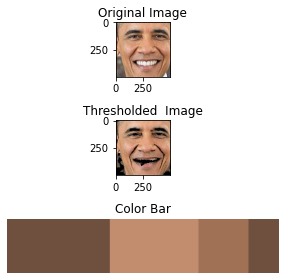

In [10]:
import numpy as np
import cv2
import cv2 as cv
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
from PIL import Image
import face_recognition


def crop(image):
    image = face_recognition.load_image_file(image)
    face_locations = face_recognition.face_locations(image)
    for face_location in face_locations:

        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        pil_image = Image.fromarray(face_image)
        pil_image.save('image/crop.jpg')

        
def color(img):
    avg = cv.mean(img)
    print(avg)
    rec = np.zeros((384, 384,3), np.uint8)
    rec = cv.rectangle(rec, (110, 110), (200, 200), avg, -1)
    cv.imshow('avg', rec)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
def extractSkin(image):
    img = image.copy()
    # BGR 색 공간에서 HSV로 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # HSV 스레드 홀드 정의
    lower_threshold = np.array([0, 51, 80], dtype=np.uint8)
    upper_threshold = np.array([21, 153, 255], dtype=np.uint8)


    # 단일 채널 마스크, 약 임계값에 색상 존재 표시
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # 가우스 필터를 이용한 마스크 정리
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # 임계값 마스크에서 피부 추출
    skin = cv2.bitwise_and(img, img, mask=skinMask)
    # 스킨 이미지 반환
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # 검정색 확인
    hasBlack = False

    # 각 색상의 총 발생 횟수를 가져옵니다.
    occurance_counter = Counter(estimator_labels)

    # 목록과 비교할 빠른 람다 함수
    def compare(x, y): return Counter(x) == Counter(y)

    # 가장 일반적인 색상 반복
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # 각 RBG 번호를 정수로 변환
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # 색상이 [0,0,0]이면 검정색인지 확인합니다.
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # 예측된 각 색상의 발생 횟수를 유지하는 변수
    occurance_counter = None

    # 반환할 출력 목록 변수
    colorInformation = []

    # 검은색 확인
    hasBlack = False

    # 마스크가 적용된 경우 검은색 제거
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # 예측된 모든 사건의 합계를 가져옵니다.
    totalOccurance = sum(occurance_counter.values())

    # 예측된 모든 색상을 루프합니다.
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # 임계값이 없을 때 인덱스의 빠른 수정 범위를 벗어남
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # 색상 번호를 목록으로 가져옵니다.
        color = estimator_cluster[index].tolist()

        # 각 색상의 백분율을 가져옵니다.
        color_percentage = (x[1]/totalOccurance)

        # 컬러 정보를 상세히 설명
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=4, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar


def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()

crop('image/obama.jpg')
image =cv2.imread('image/crop.jpg')
image = imutils.resize(image, width=500)

plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
# plt.show()

# Apply Skin Mask
skin = extractSkin(image)
cv.imshow('skin', skin)
color(skin)
plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
#plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()
